In [1]:
import numpy as np
import pandas as pd

In [2]:
nutrition = pd.read_csv("../data/features_nutrition.csv", delimiter=";", index_col=0)
seasonal = pd.read_csv("../data/recipe_seasonality_features.csv", index_col=0)
rating = pd.read_csv("../data/recipes_feature_rating_full.csv", index_col=0)
complexity = pd.read_csv("../data/recipes_features_complexity.csv", index_col=0)
ingredients = pd.read_csv("../data/features_ingredients.csv", index_col=0)

recipes = (nutrition
           .merge(seasonal, left_index=True, right_index=True)
           .merge(rating, left_index=True, right_index=True)
           .merge(complexity, left_index=True, right_index=True)
           .merge(ingredients, left_index=True, right_index=True)
           )


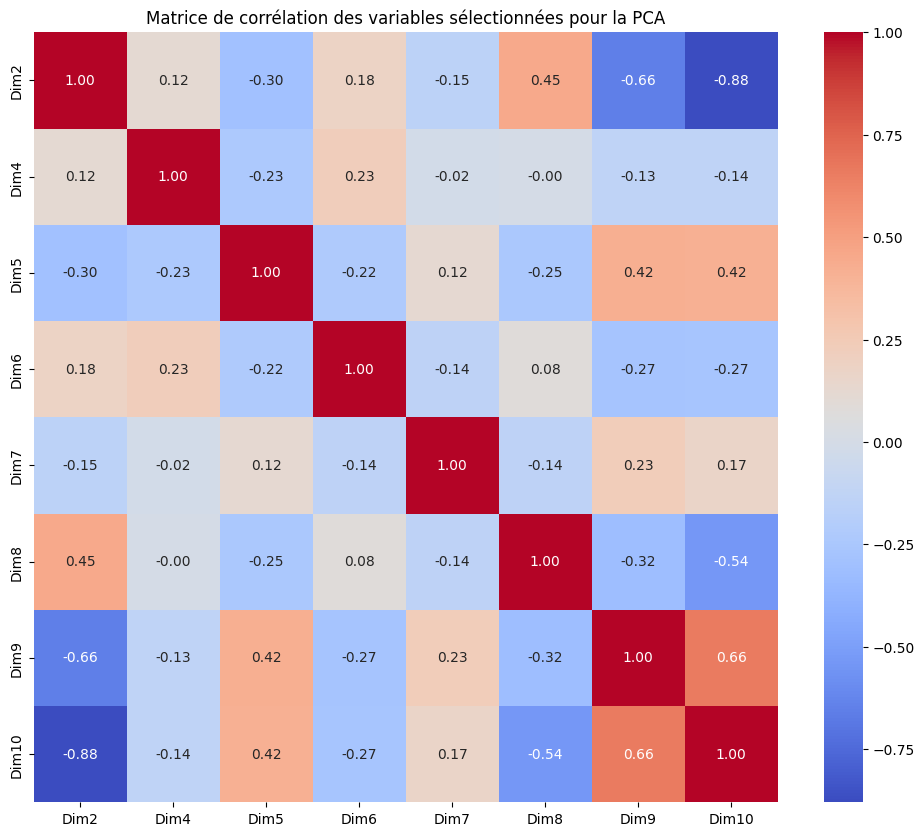

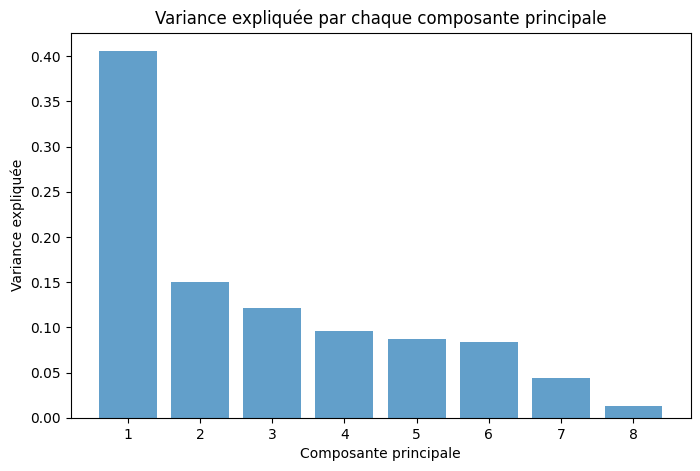

In [3]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

"""'energy_density', 'protein_ratio', 'fat_ratio',
       'nutrient_balance_index', 'inter_doy_sin_smooth',
       'inter_doy_cos_smooth', 'inter_strength', 'n_interactions',
        'bayes_mean', 'n_steps_z', 'n_ingredients_z',
       'minutes_log', """

# Sélectionner les variables pour la PCA
features = recipes[['Dim2', 'Dim4', 'Dim5', 'Dim6', 'Dim7', 'Dim8', 'Dim9', 'Dim10']]

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 10))
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation des variables sélectionnées pour la PCA')
plt.show()

# Standardiser les données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# Appliquer la PCA
pca = PCA(n_components=len(features.columns))
principal_components = pca.fit_transform(features_scaled)
# Créer un DataFrame avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])], index=recipes.index)
# Graphique des valeurs propres
import matplotlib.pyplot as plt
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante principale')
plt.show()



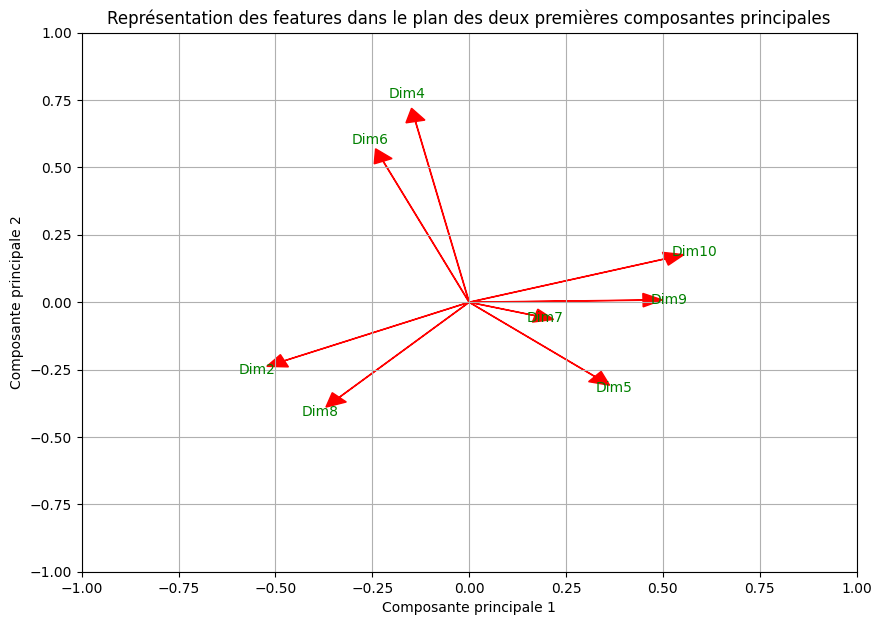

In [4]:
# Représentation des features dans le plan des deux premières composantes principales
plt.figure(figsize=(10, 7))
for i, feature in enumerate(features.columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
              head_width=0.05, head_length=0.05, fc='r', ec='r')
    plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15,
             feature, color='g', ha='center', va='center')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Représentation des features dans le plan des deux premières composantes principales')
plt.grid()
plt.show()

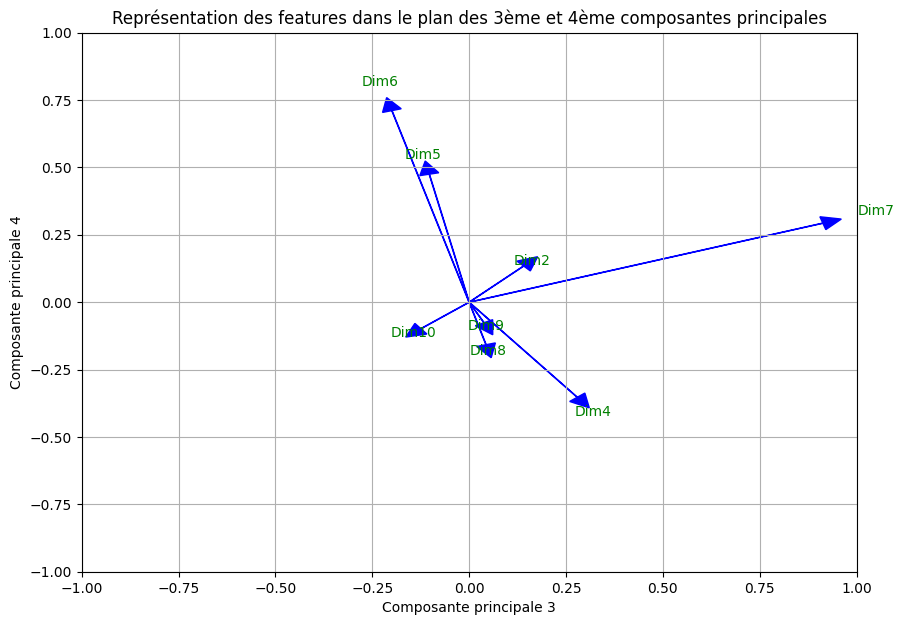

In [5]:
# Représentation des variables sur le plan des 3ème et 4ème composantes principales
plt.figure(figsize=(10, 7))
for i, feature in enumerate(features.columns):
    plt.arrow(0, 0, pca.components_[2, i], pca.components_[3, i],
              head_width=0.05, head_length=0.05, fc='b', ec='b')
    plt.text(pca.components_[2, i] * 1.15, pca.components_[3, i] * 1.15,
             feature, color='g', ha='center', va='center')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante principale 3')
plt.ylabel('Composante principale 4')
plt.title('Représentation des features dans le plan des 3ème et 4ème composantes principales')
plt.grid()
plt.show()  

In [6]:
# Afficher les contributions des variables aux composantes principales
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features.columns))], index=features.columns)
print("Contributions des variables aux composantes principales :")
print(loadings) 

Contributions des variables aux composantes principales :
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Dim2  -0.476732 -0.217210  0.140617  0.134294  0.241441 -0.249795  0.362338   
Dim4  -0.138559  0.670716  0.279000 -0.352667  0.565304  0.062435 -0.071716   
Dim5   0.324430 -0.275700 -0.102849  0.475079  0.730732 -0.029580 -0.191568   
Dim6  -0.221951  0.523283 -0.199368  0.711048 -0.161917  0.315239  0.038546   
Dim7   0.170100 -0.049792  0.912793  0.293255 -0.185696  0.037441 -0.116232   
Dim8  -0.335166 -0.352947  0.043579 -0.157676  0.093729  0.797302 -0.289169   
Dim9   0.448665  0.007729  0.038337 -0.076031  0.084402  0.438194  0.768131   
Dim10  0.506399  0.161291 -0.124503 -0.098287 -0.107513  0.065932 -0.371793   

            PC8  
Dim2   0.660120  
Dim4  -0.010826  
Dim5  -0.104470  
Dim6   0.067060  
Dim7  -0.001753  
Dim8   0.090753  
Dim9   0.047187  
Dim10  0.733654  


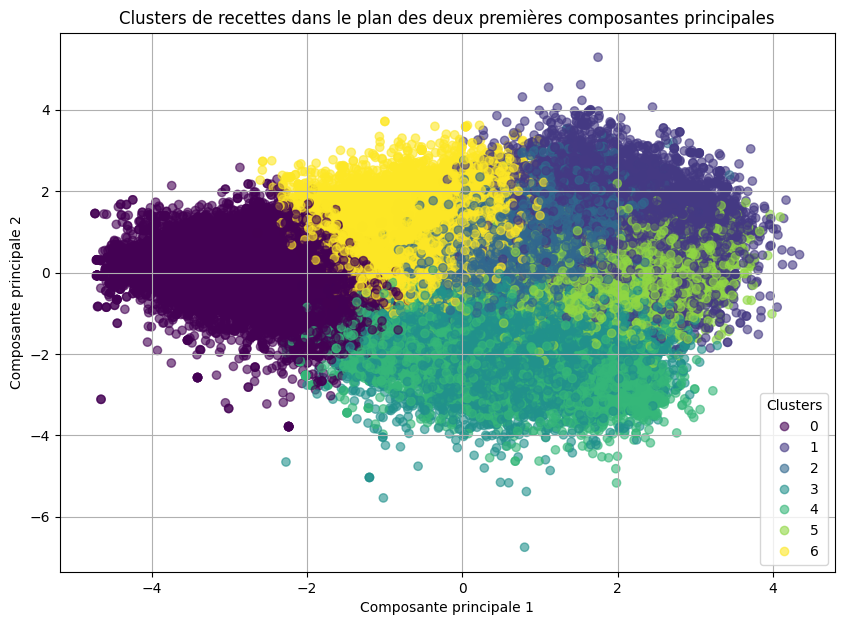

Caractéristiques moyennes des clusters :
              Dim2      Dim4      Dim5      Dim6      Dim7      Dim8  \
cluster                                                                
0        18.623116  2.415118 -3.440667  1.044950 -0.870336  1.253058   
1        -6.599152  5.210419  1.121534 -0.624831  2.152644 -1.588748   
2        -5.979000  0.250115  0.054210  1.181730 -1.873117 -0.530106   
3        -1.314812 -2.124985  0.370460 -1.961889  0.768623  1.650188   
4        14.768364 -2.440928  5.198496 -2.300399 -1.844207 -0.831393   
5        -6.052102 -1.901833 -0.725842 -1.253044  0.461205 -2.300397   
6         3.400622  4.376539 -1.171554  0.939993 -1.030731  0.029498   

             Dim9     Dim10  
cluster                      
0       -4.509382 -5.751030  
1        0.421484  1.327612  
2       -0.605558  1.044718  
3       -0.548790 -0.361160  
4       -1.486139 -2.450737  
5       -1.366891  1.844456  
6       -2.222602 -1.346845  


In [9]:
# K-means clustering sur les 12 premières composantes principales
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
recipes['cluster'] = kmeans.fit_predict(pca_df.iloc[:, :12])   
# Représentation des clusters dans le plan des deux premières composantes principales
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=recipes['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Clusters de recettes dans le plan des deux premières composantes principales')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid()
plt.show()
# Caractériser les clusters par les variables d'origine
cluster_characteristics = recipes.groupby('cluster')[features.columns].mean()
print("Caractéristiques moyennes des clusters :")
print(cluster_characteristics)






In [20]:
# Construire un dataframe avec les variables d'origine en ligne, les clusters en colonne. 
# Pour chaque cellule, la statistique de student (signée) entre le cluster et le reste des données.
from scipy.stats import ttest_ind
cluster_stats = pd.DataFrame(index=features.columns, columns=[f'cluster_{i}' for i in range(5)], dtype=float)
for i in range(5):
    cluster_data = recipes[recipes['cluster'] == i][features.columns]
    rest_data = recipes[recipes['cluster'] != i][features.columns]
    for feature in features.columns:
        t_stat, p_val = ttest_ind(cluster_data[feature], rest_data[feature], equal_var=False)
        cluster_stats.at[feature, f'cluster_{i}'] = t_stat
print("Statistiques de Student (signées) entre chaque cluster et le reste des données :")
print(cluster_stats)

Statistiques de Student (signées) entre chaque cluster et le reste des données :
        cluster_0   cluster_1   cluster_2   cluster_3   cluster_4
Dim2   539.643808 -272.517453 -225.849953  -88.007907  185.996658
Dim4   115.986803   68.527613   16.300683 -190.482956  -98.929568
Dim5  -266.589660   60.489484   23.928109   71.965784  181.231321
Dim6   147.960759  -99.159558  143.290593 -132.250457  -97.720479
Dim7   -58.579663  183.978958 -179.348120  131.151484  -54.345319
Dim8   224.480984 -216.698041  -70.259441  108.606564  -49.377776
Dim9  -344.276153  151.137233   97.401129   93.087590   12.338485
Dim10 -485.506426  266.491348  177.929456   72.926312  -46.878238


In [9]:
# explort de cluster_stats
cluster_stats.to_csv('../data/cluster_stats.csv', index=True)


In [10]:

# Affichage des noms des 20 recettes les plus proches du centre de chaque cluster
from sklearn.metrics import pairwise_distances

# Récupération des centres des clusters
centers = kmeans.cluster_centers_

# Calcul des distances entre chaque centre et chaque point
distances = pairwise_distances(centers, pca_df.iloc[:, :12])

# Pour chaque cluster, on récupère les 20 indices les plus proches
n_neighbors = 20
for i in range(len(centers)):
    # np.argsort trie les indices des distances de plus petit à plus grand
    closest_indices = np.argsort(distances[i])[:n_neighbors]
    
    print(f"\nCluster {i} – 20 recettes les plus proches du centre :")
    for idx in closest_indices:
        recipe_name = recipes.iloc[idx].get('name_x', 'unknown')
        print(f"  - {recipe_name}")









Cluster 0 – 20 recettes les plus proches du centre :
  - avocado dip
  - almond chocolate marble muffins
  - herbed olive and anchovy dip
  - grandma s vodka sauce
  - creamy tuna pasta salad
  - to die for oatmeal chip cookies
  - tilapia in a potato crust
  - herbed chicken
  - pork roast with meyer lemon glaze
  - ginger  lemon   coriander fish  soup
  - couscous with lemon and watercress
  - inside out cheeseburgers
  - raspberry horseradish sauce
  - low fat  cream  of tomato soup
  - hot rolls
  - pig pickin sauce by mean chef
  - stir fry vegetables
  - pork chops yum yum
  - chicken con rajas
  - mango chicken tarkari

Cluster 1 – 20 recettes les plus proches du centre :
  - unknownchef86 s killer zucchini relish tartar sauce
  - skillet pizzas
  - one bowl cheddar biscuits
  - delightful cranberry lemonade
  - creamy peanut butter fudge
  - chicken cucumber boats
  - hot sauteed shrimp
  - oysters kilpatrick
  - cinnamon rolls  kanelbullar
  - creamy broccoli chowder
  - scal

In [20]:
# exporter le dataframe final avec les clusters et les deux premières composantes principales
recipes = recipes[["name_x", "cluster"]].merge(pca_df[['PC1', 'PC2']], left_index=True, right_index=True)
recipes.to_csv('../data/recipes_clustering_pca.csv', index=True, columns=["name_x", 'cluster', 'PC1', 'PC2'])
